In [2]:
from sklearn.cluster import *
import scipy
import copy
import numpy as np
from matplotlib import pyplot as plt
from Bio import AlignIO
import pickle
import h5py
import dendropy
#todo. blur mat up and down tree
#todo. group codons 
#

(72513, 45950)


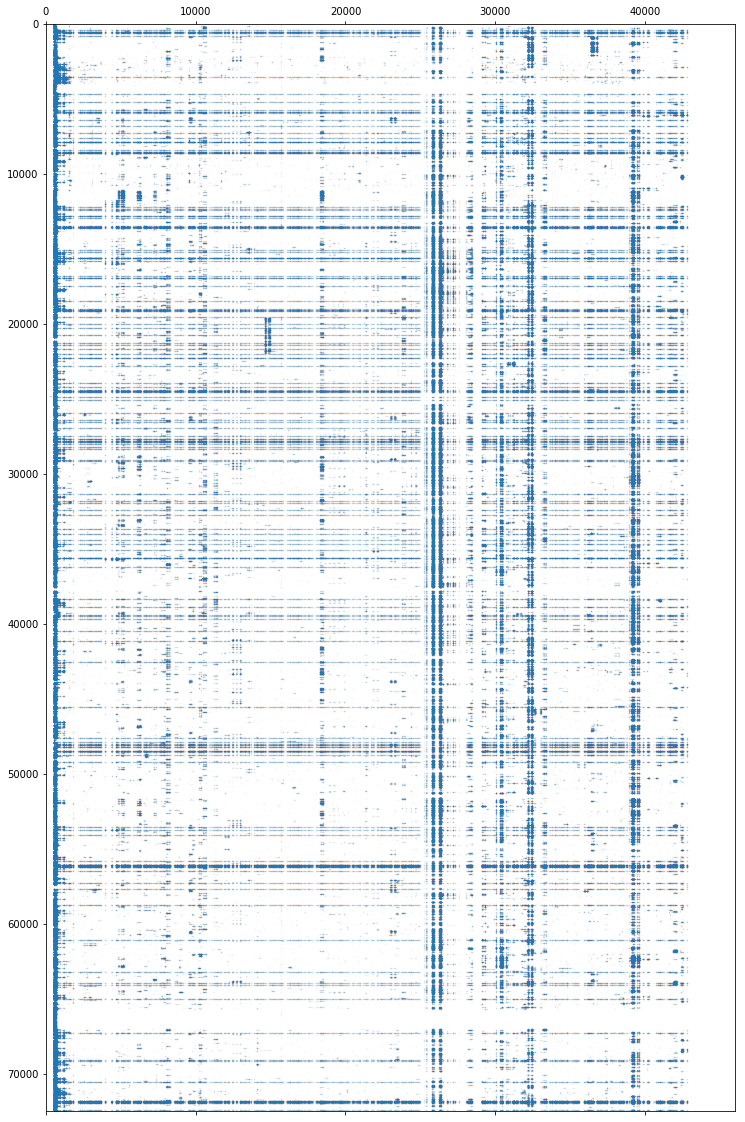

In [13]:
#load sankoff coev mat
with open( './coevmat.pkl' , 'rb') as matin:
    coevmat = pickle.loads(matin.read())
print(coevmat.shape)
plt.figure( figsize=(30,20))
plt.spy(coevmat, markersize= .01)

In [5]:
#create the connectivity mat and use it to blur the coev mat
tree = dendropy.Tree.get(
    path='./lanford/ft_TBE.tree.txt',
    schema='newick')
for l in tree.leaf_nodes()[0:10]:
    print(str(l.taxon))
print(len(tree.leaf_nodes()))
print('leaves')


for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None
    if i< 10:
        print(n)
        print(n.matrow)

            
matsize = len(tree.nodes())
print(matsize)
print('nodes')



'hCoV-19/Wuhan/WH04/2020|EPI ISL 406801|2020-01-05'
'hCoV-19/Xinyu/JX122/2020|EPI ISL 421249|2020-01-25'
'hCoV-19/Guangzhou/GZMU0046/2020|EPI ISL 429093|2020-02-08'
'hCoV-19/Wuhan/WHUH011/2020|EPI ISL 449484|2020-01-22'
'hCoV-19/Sichuan/SC-WCH3-255/2020|EPI ISL 451384|2020-01-27'
'hCoV-19/Guangzhou/GZMU0048/2020|EPI ISL 414691|2020-02-25'
'hCoV-19/Nanchang/JXN3T4/2020|EPI ISL 421246|2020-02-26'
'hCoV-19/Guangzhou/GZMU0078/2020|EPI ISL 457690|2020-02-11'
'hCoV-19/Ganzhou/JX81/2020|EPI ISL 421242|2020-01-25'
'hCoV-19/Shangrao/JX29/2020|EPI ISL 421244|2020-01-22'
36257
leaves
<Node object at 0x7fea96f84cc0: 'None' (None)>
0
<Node object at 0x7fec082924e0: 'None' (<Taxon 0x7fec08292518 'hCoV-19/Wuhan/WH04/2020|EPI ISL 406801|2020-01-05'>)>
1
<Node object at 0x7fec08292588: '0.010000' (None)>
2
<Node object at 0x7fea983e6320: 'None' (<Taxon 0x7fea96f84dd8 'hCoV-19/Xinyu/JX122/2020|EPI ISL 421249|2020-01-25'>)>
3
<Node object at 0x7fea96f84e48: '0.025000' (None)>
4
<Node object at 0x7fea96f8

In [74]:
import h5py
#calculate a distmat between cols w events
def distfun(v1,v2):
    #distance function between two continuous vectors
    #euclidean dist
    return np.linalg.norm( v1-v2 )
    
def process(q,retq, iolock):
    #calculate compression distances
    with iolock:
        print('init worker')
    from time import sleep
    while True:
        stuff = q.get()
        if stuff is None:
            break
        retq.put(distfun(stuff))
    print('done')

def mat_creator(retq,matsize,iolock):
    with iolock:
        print('init matcreator')
    #collect distances and create final mat
    calculations = (matsize**2 - matsize) / 2
    distmat = np.zeros((matsize,matsize))
    count = 0
    with h5py.File('./UKdata/alnEventdistmat.h5', 'a') as hf:
        try:
            hf.create_dataset("alnEventdists",  data=distmat)
        except:
            pass
        while True:
            r = retq.get()
            count+=1
            if r is None:
                break
            row,col,cdist = r
            hf['alnMI'][row,col] = cdist
            if count% 100000 == 0 :
                with iolock:
                    print(count/calculations)
                    print((row,col))
                    hf.flush()
    print('done saver')

startk = 0 
startl = 0

if __name__ == '__main__':
    NCORE = 64
    q = mp.Queue(maxsize=NCORE*5000)
    retq = mp.Queue(maxsize=NCORE*5000)
    iolock = mp.Lock()
    pool = mp.Pool(NCORE, initializer=process, initargs=(q,retq, iolock))
    p = mp.Process(target=mat_creator, args=(retq,len(msa[1,:]), iolock))
    p.start()
    
    for k,i in enumerate(informativesites):
        for l,j in enumerate(informativesites):
            if k < l and k> startk and l > startl :
                s1 = coevmat[:,i].ravel()
                s2 = coevmat[:,j].ravel()
                q.put( (i,j,s1,s2) )         
                if k % 100 == 0 and l %100 == 0:
                    print((k,l))
                    print((i,j))
    
    for _ in range(NCORE):  # tell workers we're done
        q.put(None)
    retq.put(None)
    pool.close()
    pool.join()
    p.join()
    
    
    

NameError: name 'mp' is not defined

In [ ]:
print(coevmat)
coevmat= coevmat[matrows,:]
plt.figure( figsize=(30,20))
plt.spy(coevmat, markersize= .01)

In [4]:

#blur w connectivity mat
blurfactor =  .5
bluriter = 4

connectmat = scipy.sparse.lil_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
connectmat[index[:,0],index[:,1]] = 1
connectmat+= connectmat.T

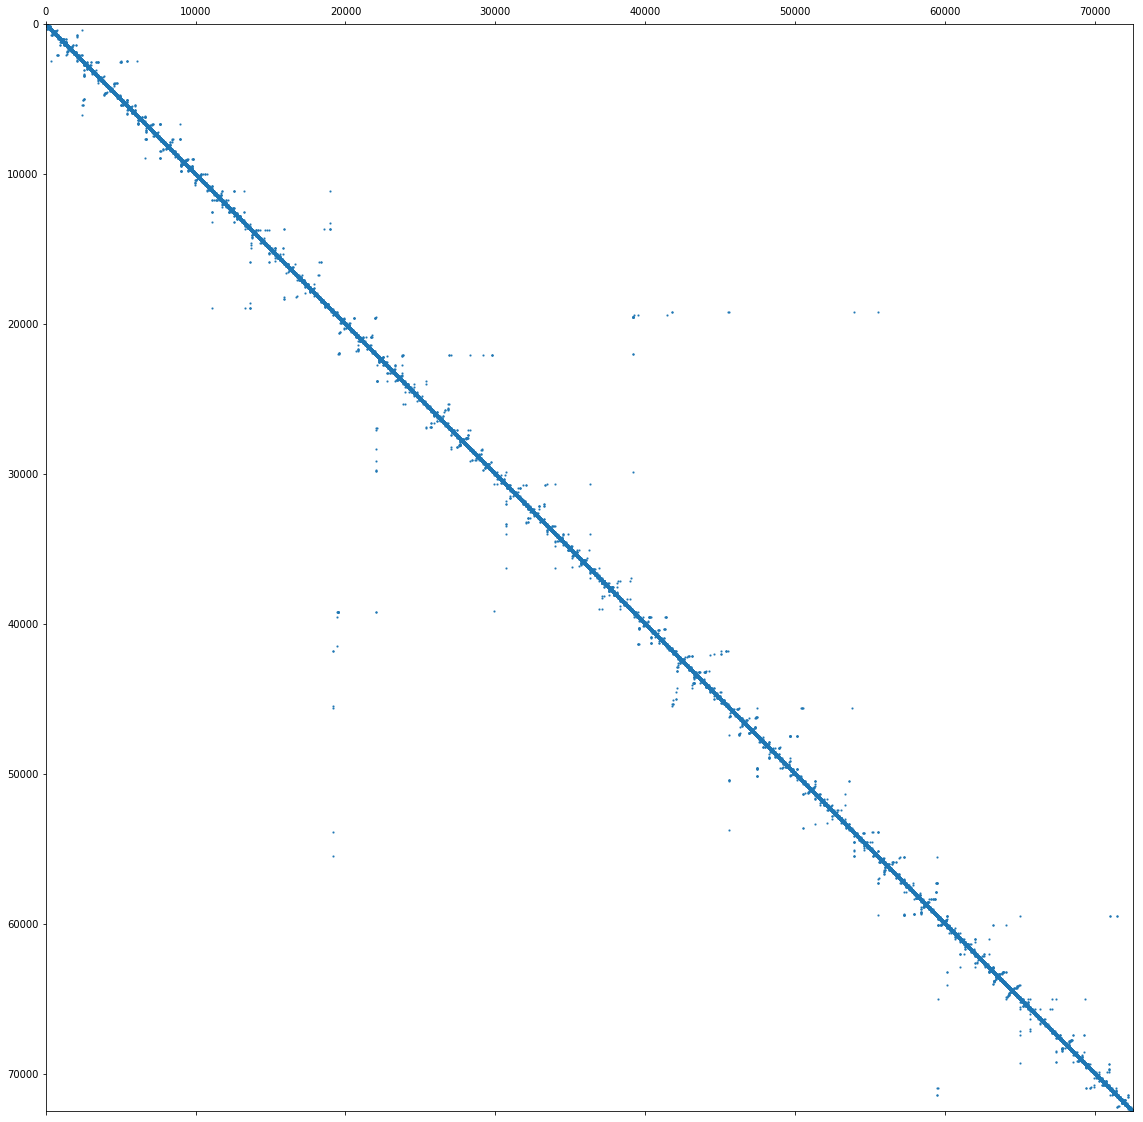

In [5]:
plt.figure( figsize=(20,20))
plt.spy(connectmat, markersize= 1)
plt.show()

In [6]:
#apply blur a few times
blurmat = copy.deepcopy(coevmat)
print(connectmat.shape)
print(blurmat.shape)
for i in range( bluriter):
    blurmat += np.dot(blurfactor*connectmat, blurmat)
    print('blurring')
    print(i)

(72513, 72513)
(72513, 45950)
blurring
0
blurring
1
blurring
2
blurring
3


In [9]:
with open('./gisaid/blurmat.pkl' , 'wb') as blurout:
    blurout.write( pickle.dumps(blurmat ))


In [15]:
with open('./gisaid/blurmat.pkl' , 'rb') as blurout:
    blurmat = pickle.loads( blurout.read())
blurmat = blurmat.todense()

In [3]:

with open( 'blurmat_codons.pkl' , 'rb') as blurout:
    blurmat = pickle.loads(blurout.read())
    

In [4]:
blursum = np.sum(blurmat , axis = 1)
print(blursum.shape)
posi= blursum[blursum>0]
print(posi[0,:].shape)
print(posi)



(72513, 1)
(1, 63440)
[[ 1.     15.0625  5.5    ... 54.     54.     22.125 ]]


In [5]:
print(blurmat.shape)

(72513, 9950)


In [6]:
plt.hist(np.random.choice( posi[0,:].ravel() , 1000 ))

ValueError: a must be 1-dimensional

(49392, 9950)


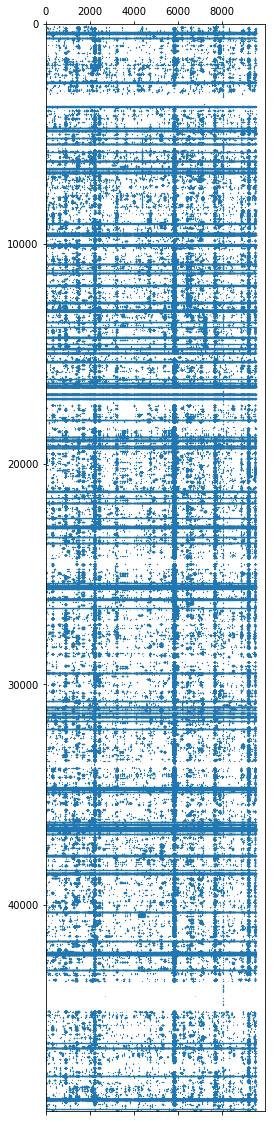

In [7]:
blurmat = blurmat[np.where(blursum<1000)[0],:]
print(blurmat.shape)
plt.figure( figsize=(20,20))
plt.spy(blurmat, markersize= .1)
plt.show()


In [8]:
#cluster the informative columns evol events
from sklearn.cluster import MiniBatchKMeans

apb = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=100, batch_size=100, verbose=0, compute_labels=True )

#apb = DBSCAN( eps = .2 , metric='jaccard', metric_params=None, algorithm='auto', leaf_size=25, p=None, n_jobs=-1)
cluster_labelsb = apb.fit_predict(blurmat.T )
print(cluster_labelsb[1000:1200])


[ 1 50  5 50  5 50  5  5  5  5  5  5  5  5  5  1  5  5  5  5  1 50  5  5
  1  5  5 50 50  5 50  5 50  1 50 50  1 50  5  1 50  1  1 50  5  5 50  5
  5 50  5  5  5  1 50  5  5 50  5  5  5  5 50  5  5  5 50  5  5  5  5  5
  5 50 50  5 81 81  5 81  5 81  5  5 81  5 50  5  1  5 81  0  5  5  5 50
  5 50 50  5  5  0  1  0  0  0  1  5  5  5  5  5  0  0  0  5 50  5  5 50
  0  5  5  5  0 50  5  5  5  5  5  1 81  1 81  5 50 81  5  5  5 50 50 50
 50  5  5 50  5 81  5  5  5  5  5  5  5  5 50 50  5  5  5  5 50  5 50  5
  5  5  5  5 50  5  5 50  1  1  1 50  5  5  1  5 50  1  5  5 50  5  5 50
  5  5  5  5  1  1  5 50]


In [51]:
l,c = np.unique(cluster_labelsb, return_counts= True)
print(len(l))
print(c)
print(np.sum(c))



61
[  10 2032    6    4   54 5337   25   52    7   20   21    1   29   28
   20    1    2    4    8   13   28    7   18   30   15    2   22    4
    5   16   15    1   34   20   11    6   40   30 1647    1    1    3
   14   33   30   20   37    2    7    4   12   18   12   17    6   43
   18   14   24    7    2]
9950


In [50]:
#save each cl
import colour
import numpy as np

red = colour.Color('red')
blue = colour.Color('blue')
crange = [ c.get_hex_l() for c in red.range_to(blue, len(np.unique(cluster_labelsb))) ]
print(crange)

with open( 'crange.pkl' , 'wb') as crangeout:
    crangeout.write(pickle.dumps(crange))

['#ff0000', '#ff1100', '#ff2200', '#ff3300', '#ff4400', '#ff5500', '#ff6600', '#ff7700', '#ff8800', '#ff9900', '#ffaa00', '#ffbb00', '#ffcc00', '#ffdd00', '#ffee00', '#ffff00', '#eeff00', '#ddff00', '#ccff00', '#bbff00', '#aaff00', '#99ff00', '#88ff00', '#77ff00', '#66ff00', '#55ff00', '#44ff00', '#33ff00', '#22ff00', '#11ff00', '#00ff00', '#00ff11', '#00ff22', '#00ff33', '#00ff44', '#00ff55', '#00ff66', '#00ff77', '#00ff88', '#00ff99', '#00ffaa', '#00ffbb', '#00ffcc', '#00ffdd', '#00ffee', '#00ffff', '#00eeff', '#00ddff', '#00ccff', '#00bbff', '#00aaff', '#0099ff', '#0088ff', '#0077ff', '#0066ff', '#0055ff', '#0044ff', '#0033ff', '#0022ff', '#0011ff', '#0000ff']


0
10
4
54
6
25
7
52
8
7
9
20
10
21
12
29
13
28
15
20
23
8
24
13
25
28
26
7
27
18
28
30
30
15
34
22
37
16
38
15
41
34
42
20
43
11
45
40
48
30
59
14
61
33
64
30
66
20
72
37
74
7
77
12
80
18
81
12
84
17
87
43
90
18
91
14
92
24
95
7


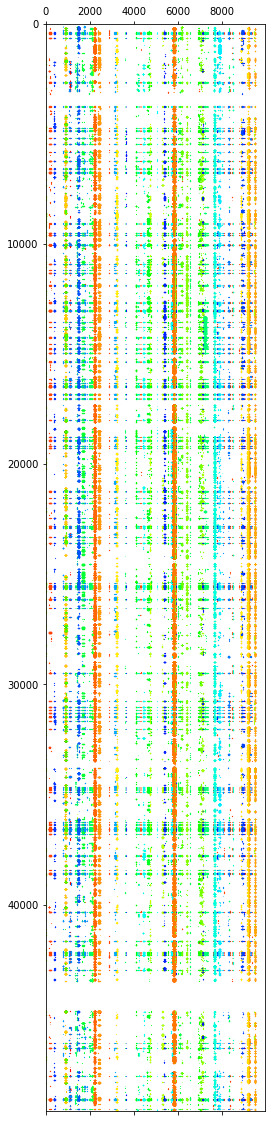

In [11]:
blurmat = blurmat.todense()
plt.figure( figsize=(30,20))
for i,l in enumerate(np.unique(cluster_labelsb)):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        print(l)
        print( len(cluster_labelsb[ cluster_labelsb==l ] ) )
        mask =  copy.deepcopy(blurmat)
        mask[:,  cluster_labelsb!=l ] = 0
        plt.spy(mask, markersize = .1 , mfc = crange[i]  , mec = crange[i] )
        
plt.show()


In [13]:
#make a df with clusters for each sequence
#these can be added to the prot struct distmats

import pandas as pd
annotation = pd.read_csv('./gisaid/hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06.csv')
print(annotation)

    Unnamed: 0    qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0            3  testgeno  YP_009725299.1  29848  1945    2698   8532       1   
1           11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
2           13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
3           14  testgeno  YP_009725298.1  29848   638     784   2697       1   
4           16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
5           17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
6           18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
7           20  testgeno  YP_009725310.1  29848   346   19599  20636       3   
8           21  testgeno  YP_009724397.2  29848   419   28252  29508       1   
9           22  testgeno  YP_009725301.1  29848   306   10033  10950       1   
10          24  testgeno  YP_009725311.1  29848   298   20637  21530       3   
11          25  testgeno  YP_009724391.1

In [15]:
count = 0
starts = []
stops =[]
for seq in annotation.prots:
    starts.append( count )
    stops.append( count+len(seq) )
    count += len(seq)
annotation['start'] =  starts
annotation['stop'] = stops
print(annotation)

    Unnamed: 0    qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0            3  testgeno  YP_009725299.1  29848  1945    2698   8532       1   
1           11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
2           13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
3           14  testgeno  YP_009725298.1  29848   638     784   2697       1   
4           16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
5           17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
6           18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
7           20  testgeno  YP_009725310.1  29848   346   19599  20636       3   
8           21  testgeno  YP_009724397.2  29848   419   28252  29508       1   
9           22  testgeno  YP_009725301.1  29848   306   10033  10950       1   
10          24  testgeno  YP_009725311.1  29848   298   20637  21530       3   
11          25  testgeno  YP_009724391.1

In [49]:
clusters = {}
import json

for l in np.unique(cluster_labelsb):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        #index of positions
        cluster_postions = np.where( cluster_labelsb==l )
        print(cluster_postions)
        
        for i,r in annotation.iterrows():
            for p in list(cluster_postions[0]):
                
                if r.start < p and r.stop > p:
                    
                    if i not in clusters:
                        clusters[i] = {}
                        
                    if l not in clusters[i]:
                        clusters[i][l] = []
                    
                    clusters[i][l].append(p-r.start)

print(clusters)
annotation['clusters']= annotation.index.map( clusters )

#annotation['clusters'] = annotation.clusters.map( lambda x : json.dumps( x ) )
print(annotation)

annotation.to_csv('./gisaid/hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06_wclusters.csv')

with open( 'annothack.pkl' , 'wb') as annotout:
    annotout.write(pickle.dumps(annotation))

(array([1091, 1101, 1103, 1104, 1105, 1112, 1113, 1114, 1120, 1124]),)
(array([ 170,  171,  172,  173,  174,  175,  176,  177,  180,  181,  182,
        189,  191,  192,  194,  195,  197,  199,  201,  203,  216,  217,
        224,  228,  230,  232,  235,  236,  241,  242,  249, 1786, 2474,
       2869, 2881, 4263, 4270, 4327, 5557, 6210, 6948, 7585, 7786, 7788,
       7826, 7829, 8087, 8366, 8395, 8472, 8782, 8903, 9053, 9356]),)
(array([2190, 2193, 2195, 2198, 2204, 2207, 2211, 2219, 2221, 2223, 2224,
       2225, 2228, 2232, 2233, 2235, 2236, 2237, 2240, 2241, 2243, 2244,
       2247, 2251, 2254]),)
(array([5788, 5790, 5791, 5795, 5800, 5802, 5803, 5804, 5805, 5807, 5808,
       5809, 5810, 5813, 5814, 5815, 5820, 5821, 5822, 5823, 5825, 5826,
       5827, 5829, 5830, 5831, 5832, 5833, 5834, 5838, 5839, 5840, 5841,
       5842, 5843, 5844, 5847, 5848, 5849, 5850, 5851, 5853, 5855, 5857,
       5860, 5863, 5865, 5866, 5869, 5871, 5873, 5875]),)
(array([9232, 9239, 9242, 9243, 9244, 92

In [ ]:
#order by tree depth
matrows = []
max_degree = max( [ n.level() for n in tree.leaf_nodes() ])
print(max_degree)

for i in range(max_degree):
    filter_fn = lambda n: hasattr(n, 'level') and n.level() == i
    nodes = tree.find_nodes(filter_fn=filter_fn)
    for n in nodes:
        matrows.append(n.matrow)
#reorder based on tree depth
print(matrows[0:100])
#filter by neighborhood branch support measure?



In [ ]:
#filter down to one sequence
#load aln
with h5py.File('./UKdata/aln.h5', 'r') as hf:
    align_array = hf['MSA2array'][:]
msa = AlignIO.read('./gisaid/msa_0612.lenfilter.fasta' , format = 'fasta')
def clipID(ID):
    return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
IDs = {i:clipID(rec.id) for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )

In [ ]:
print(coevmat.shape)
print(submat_coev.shape)

In [ ]:
ap = DBSCAN( eps = 2 , metric='euclidean', metric_params=None, algorithm='ball_tree', leaf_size=20, p=None, n_jobs=-1)
cluster_labels = ap.fit_predict(submat_coev.T )


In [ ]:
import colour
crange = len(np.unique(cluster_labels))
red = colour.Color('red')
blue = colour.Color('blue')
colorhex = [ str(c.get_hex_l()) for c in red.range_to(blue, crange) ]
colorhex = dict(zip(np.unique(cluster_labels) , colorhex))

In [ ]:
plt.figure( figsize=(30,20))
for l in np.unique(cluster_labels):
    if len(cluster_labels[ cluster_labels==l ] ) < 200 and len(cluster_labels[ cluster_labels==l ] ) > 6:
        print(l)
        print( len(cluster_labels[ cluster_labels==l ] ) )
        mask =  scipy.sparse.lil_matrix(copy.deepcopy(submat_coev))
        mask[:,  cluster_labels!=l ] = 0
        plt.spy(mask, markersize = .1 , mfc  = colorhex[l] )
plt.show()

[563, 564, 565, 566, 567, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 898]
[b'-' b'-' b'-' ... b'-' b'-' b'-']
b'GGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCA'


FileNotFoundError: [Errno 2] File outannot.txt does not exist: 'outannot.txt'

In [ ]:
#distmat of treedists on codons 

In [ ]:
#distmat of compress dist

#cluster

#spatial distmat of residues